In [1]:
#%load_ext memory_profiler

######################
#import useful modules
######################

import sys

sys.path.append("/home/gula/Desktop/Work_capella/Python/Python_Modules_p3/") 
from Modules import *

%matplotlib inline


In [2]:
# Load simulation

simul_gigatl6 = load('gigatl6_1h_UP3_mean',output=False)


In [7]:

# Functions to compute barotropic streamfunctions

#################

def mypsi(simul):
    
    '''
    Basic integration of barotropic u,v to compute barotropic streamfunction
    
    '''
    
    u = var('ubar',simul).data
    v = var('vbar',simul).data

    [z_r,z_w] = tools.get_depths(simul)
    Hz = (z_w[:,:,-1] - z_w[:,:,0]); #Hz[Hz==0] = np.nan
    del z_r, z_w

    u = 0.5*(Hz[1:,:] + Hz[:-1,:])* u \
      * 2 /(simul.pn[1:,:]+simul.pn[:-1,:])
    v = 0.5*(Hz[:,1:] + Hz[:,:-1])* v \
      * 2 /(simul.pm[:,1:]+simul.pm[:,:-1])
            
    lx,ly = simul.pm.shape[0]-1,simul.pm.shape[1]-1

    psi = np.zeros((lx,ly))*np.nan
    psi[0,:] = -1*np.cumsum(u[0,:-1])
    psi[:,0] = np.cumsum(v[:-1,0])

    for i in range(1,lx):
        for j in range(1,ly):
            psi[i,j]= psi[i-1,j-1] + (v[i,j-1] - u[i,j])

    return psi*tools.rho2psi(simul.mask)


#######

def mypsi_onlyrot(simul):
        
    '''
    Basic integration of the rotational part of barotropic u,v to compute barotropic streamfunction
    
    '''
    u = var('ubar',simul).data
    v = var('vbar',simul).data

    [z_r,z_w] = tools.get_depths(simul)
    Hz = (z_w[:,:,-1] - z_w[:,:,0]); #Hz[Hz==0] = np.nan
    del z_r, z_w

    u = 0.5*(Hz[1:,:] + Hz[:-1,:])* u \
      * 2 /(simul.pn[1:,:]+simul.pn[:-1,:])
    v = 0.5*(Hz[:,1:] + Hz[:,:-1])* v \
      * 2 /(simul.pm[:,1:]+simul.pm[:,:-1])
          
    u_div,v_div = div2uv_variable(u,v,simul.pm,simul.pn)
    u,v = u-u_div, v-v_div

    lx,ly = simul.pm.shape[0]-1,simul.pm.shape[1]-1

    psi = np.zeros((lx,ly))*np.nan
    psi[0,:] = -1*np.cumsum(u[0,:-1])
    psi[:,0] = np.cumsum(v[:-1,0])

    for i in range(1,lx):
        for j in range(1,ly):
            psi[i,j]= psi[i-1,j-1] + (v[i,j-1] - u[i,j])

    return psi*tools.rho2psi(simul.mask)



#############


from scipy.sparse import *
from scipy.sparse.linalg import spsolve

######################################################  
def poisson_matrix_fast(pm,pn):    
######################################################  
    '''
    Create Poisson matrix (quick version)
    
    '''
    print('using poisson_matrix_fast')
    # elliptic equation matrix:  d_xx + d_yy
    [nx,ny] = pm.shape
    
    ############################

    Dxx = spdiags([-pm[:,ny//2]**2, 2*pm[:,ny//2]**2, -pm[:,ny//2]**2], [-1, 0, 1], nx, nx)
    Dyy = spdiags([-pn[nx//2,:]**2, 2*pn[nx//2,:]**2, -pn[nx//2,:]**2], [-1, 0, 1], ny, ny)
    A = kronsum(Dxx, Dyy)

    return A


##################
# test with variable pm,pn

def div2uv_variable(u,v,pm,pn,verbo=False,fast=True,potential=False,amg=False):
    
    '''
    Compute divergent potential or divergent part of the velocity 
    
    '''
    
    # compute div
    div = np.zeros(pm.shape)
    div[1:-1,:] = div[1:-1,:] + tools.diffx(u,tools.rho2u(pm))
    div[:,1:-1] = div[:,1:-1] + tools.diffy(v,tools.rho2v(pn))
    div[np.isnan(div)] =0
    
    # solve poisson
    # A = poisson(div.shape, format='csr')   # 2D Poisson problem 
    #######################################################
    #Create matrix A
    #######################################################    
    print('creating matrix A')
    if fast:
        A = poisson_matrix_fast(pm,pn)

    #######################################################
    #Solve matrix A
    A = A.tocsr()
    #######################################################

    b = -1*div.flatten() # right hand side
    if amg:
        ml =ruge_stuben_solver(A)                # construct the multigrid hierarchy
        if verbo: print(ml)                       # print hierarchy information
        x = ml.solve(b, tol=1e-10)               # solve Ax=b to a tolerance of 1e-8
    else:
        x = spsolve(A,b)

    if verbo: print("residual norm is", norm(b - A*x))  # compute norm of residual vector

    if potential:
        chi = x.reshape(div.shape)
        return chi
    else:
        udiv = tools.diffx(x.reshape(div.shape),pm)
        vdiv = tools.diffy(x.reshape(div.shape),pn)
        return udiv,vdiv


##################
# Compute:

psi_gigatl6_basic = mypsi(simul_gigatl6) * 1e-6

psi_gigatl6_onlyrot = mypsi_onlyrot(simul_gigatl6) * 1e-6



creating matrix A
using poisson_matrix_fast


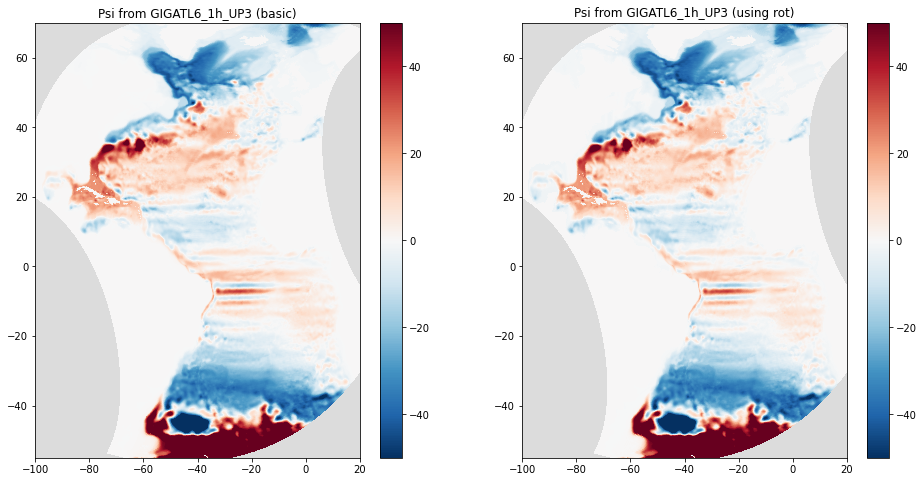

In [8]:

####

fig=plt.figure(figsize=(16.,8.),facecolor='white', edgecolor='black')

########################################################################

minlon,maxlon,minlat,maxlat=[-100.,20.,-55.,70.]
levels = np.linspace(-50,50,5)

########################################################################


ax2 = fig.add_subplot(121,facecolor='Gainsboro')  
plt.pcolormesh(simul_gigatl6.x, simul_gigatl6.y, psi_gigatl6_basic, vmin=levels.min(), vmax=levels.max(), cmap='RdBu_r')

plt.axis([minlon,maxlon,minlat,maxlat])
plt.title('Psi from GIGATL6_1h_UP3 (basic)')
plt.colorbar()

########################################################################

ax2 = fig.add_subplot(122,facecolor='Gainsboro')  
plt.pcolormesh(simul_gigatl6.x, simul_gigatl6.y, psi_gigatl6_onlyrot, vmin=levels.min(), vmax=levels.max(), cmap='RdBu_r')

plt.axis([minlon,maxlon,minlat,maxlat])
plt.title('Psi from GIGATL6_1h_UP3 (using rot)')
plt.colorbar()


########################################################################
